# Look through the data we have

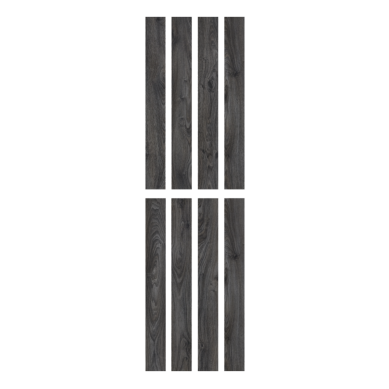

In [3]:
# Import libs
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image_path = '../data/floor/82738268_06.png'
img = mpimg.imread(image_path)

# Plot the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Some 'strange' examples

In our dataset, we have the following picture: `13.png`. It has an alpha channel and it was impossible to cut out the boards from it without proper handling:

In [4]:
import cv2
import matplotlib.pyplot as plt

# Read the image
image_path = '../data/floor/13.png'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)

# Display the image - it has 'artifacts'
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# Read the image with alpha channel
img = cv2.imread('../data/floor/13.png', cv2.IMREAD_UNCHANGED)
# Check if the image has an alpha channel
if img.shape[2] == 4:
    print("Image has an alpha channel")
    # Convert to RGB (with the alpha channel)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image - no more 'artifacts'
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [122]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def extract_boards(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

    # Minimum width and height of contours we want to extract
    min_width = image.shape[1] // 20
    min_height = image.shape[0] // 2.4

    # Calculations of kernel sizes for blur and closing
    radius_w = image.shape[1] // 200 - (image.shape[1] // 200) % 2 + 1
    radius_h = image.shape[0] // 200 - (image.shape[0] // 200) % 2 + 1
    
    # Handling of alpha channel
    if image.shape[2] == 4:
        print('alpha channel')
        rgb = cv2.cvtColor(image[:, :, :3], cv2.COLOR_BGR2RGB)
        rgb = np.ascontiguousarray(rgb, dtype=np.uint8)
        alpha = image[:, :, 3]
        gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
        gray = cv2.merge([gray, gray, gray, alpha])
    else:
        print('no alpha channel')
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray = image

    # Blurring and closing the image -> better Canny edge detection
    blurred = cv2.GaussianBlur(gray, (radius_h, radius_w), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (radius_h, radius_w))
    closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel)

    plt.imshow(closed)
    plt.axis('off')
    plt.show()
    
    # Detecting edges and contours
    edged = cv2.Canny(closed, 10, 220)
    contours, _ = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    boards = []     
    for i, contour in enumerate(contours):

        # Extracting the bounding box and checking its size
        x, y, w, h = cv2.boundingRect(contour)
        if w >= min_width and h >= min_height:

            # Extracting boards
            board = image[y:y+h, x:x+w]
            boards.append(board)

            cv2.rectangle(rgb, (x, y), (x+w, y+h), (255, 0, 0), radius_w)
    if image.shape[2] == 4:
        rgb = cv2.merge((rgb, alpha))
    plt.imshow(rgb)
    plt.axis('off')
    plt.show()
    return boards

alpha channel


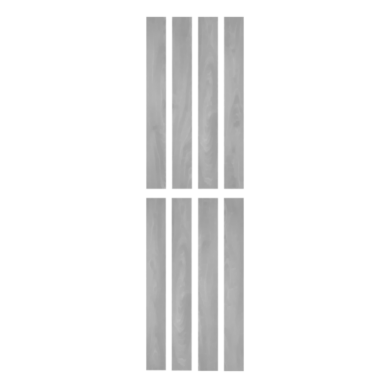

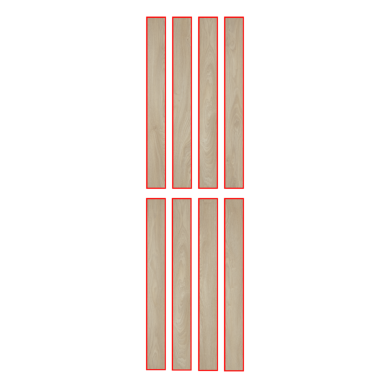

no alpha channel


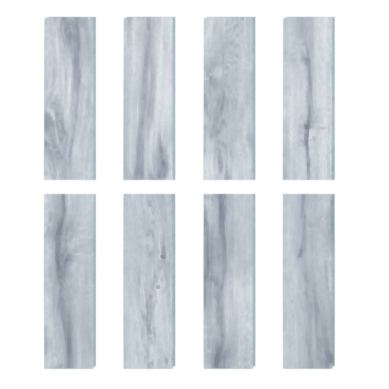

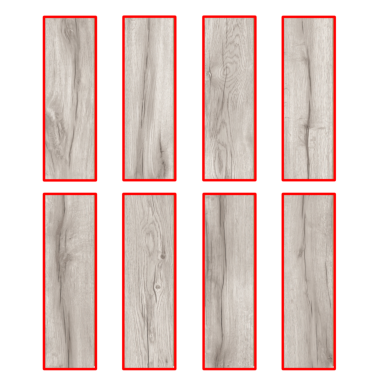

In [123]:
boards1 = extract_boards('../data/floor/2.png')
boards15 = extract_boards('../data/floor/15.jpg')

We observe that now, we can extract boards from pictures with alpha channels and without them.

# Prepare a dataset

In [1]:
import os

input_folder = '../data/floor'
output_folder = '../data/laminate_boards'

# Make an output directory
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Look for all files in the dataset and extract boards
for filename in os.listdir(input_folder):
    if filename.endswith('.webp') or filename.endswith('.png') or filename.endswith('.jpg'):
        file_path = os.path.join(input_folder, filename)
        boards = extract_boards(file_path)
        for i, board in enumerate(boards):
            output_filename = f'{os.path.splitext(filename)[0]}_board_{i}.png'
            cv2.imwrite(os.path.join(output_folder, output_filename), board)

NameError: name 'extract_boards' is not defined